Data reference : https://www.kaggle.com/c/rossmann-store-sales/data

This original Kaggle project requirement is to predict both Customers and Sales. This project analysis is limited to Sales only.

In [1]:
# Loading the required Python libraries

import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as datetime

In [2]:
# Importing the dataset as pandas data frame
store_df = pd.read_csv('store.csv')
train_df = pd.read_csv('train.csv', parse_dates = True, index_col = 'Date')

In [3]:
# An overview of the Train and Store dataframes
print('The sample of the STORE dataframe is shown below and the dataframe has the following dimensions : ', store_df.shape)
store_df.head(5)

The sample of the STORE dataframe is shown below and the dataframe has the following dimensions :  (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
print('The sample of the TRAIN dataframe is shown below and the dataframe has the following dimensions : ', train_df.shape)
train_df.head(5)

The sample of the TRAIN dataframe is shown below and the dataframe has the following dimensions :  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [5]:
# Dealing with missing values - Store dataframe
print("The missing values in the store dataframe :\n", store_df.isnull().sum())

# Removing features with high % of missing values
store_df = store_df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval'], axis = 1)
print('After features removal, the STORE dataframe has the following dimensions : ', store_df.shape)

The missing values in the store dataframe :
 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64
After features removal, the STORE dataframe has the following dimensions :  (1115, 5)


The Distribution of non-missing values of Competition Distance in Store Dataframe : 



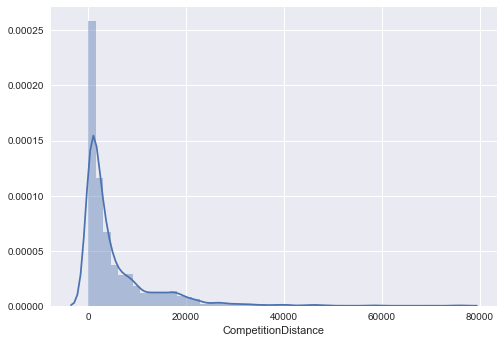

In [6]:
# Replacing missing values 
print('The Distribution of non-missing values of Competition Distance in Store Dataframe : \n')
sns.distplot(store_df.CompetitionDistance.dropna())
plt.show()

From the above distribution plot, we can see that the values are mostly right skewed. Hence, median imputation would be an appropriate method in this case.

In [7]:
# Replacing Competition Distance missing value with median
store_df.CompetitionDistance.fillna(store_df.CompetitionDistance.median(), inplace = True)

# Replacing other missing values with 0
store_df.fillna(0, inplace = True)

In [8]:
# Dealing with missing values - Train dataframe
print("The missing values in the Train dataframe :\n", train_df.isnull().sum())

The missing values in the Train dataframe :
 Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


According to the above results, the train dataframe does not have any missing values

In [9]:
# Feature Engineering - adding a set of new variables on the train data
train_df['Year'] = train_df.index.year
train_df['Month'] = train_df.index.month
train_df['Day'] = train_df.index.day
train_df['WeekofYear'] = train_df.index.weekofyear

train_df['SalesPerCustomer'] = train_df.Sales / train_df.Customers
print('Exploring all the new column - SalesPerCustomer in depth: \n', train_df.SalesPerCustomer.describe())

Exploring all the new column - SalesPerCustomer in depth: 
 count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64


In [10]:
# Revisiting the missing values on the train dataframe
print("The missing values in the Train dataframe :\n", train_df.isnull().sum())

The missing values in the Train dataframe :
 Store                    0
DayOfWeek                0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Year                     0
Month                    0
Day                      0
WeekofYear               0
SalesPerCustomer    172869
dtype: int64


172,869 records i.e., about 20% of our data has zero dollars. Most of this data belongs to stores that are no longer Open. It is important to remove these Stores from our analysis to avoid baised forecasts.

Also, there are few records in which the open stores have zero dollar sales even that being a working data. Since, the effected records are smaller in number, we assume some factors like - data entry or external forces involved and drop them from our analysis.

In [11]:
train_df = train_df[(train_df.Open != 0) & (train_df.Sales != 0)]
train_df = train_df[train_df['Sales']!=0]

print('Exploring the sales column in depth: \n', train_df.Sales.describe())

Exploring the sales column in depth: 
 count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64


In [12]:
# Joining the two dataframes - Train and Store

train_combined_df = pd.merge(train_df, store_df, how = 'inner', on = 'Store')
print('The sample of the STORE dataframe is shown below and the dataframe has the following dimensions : ', train_combined_df.shape)
train_combined_df.head(5)

The sample of the STORE dataframe is shown below and the dataframe has the following dimensions :  (844338, 17)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,0
1,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,0
2,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,0
3,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,0
4,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,0


In [13]:
# Additional cleaning on the dataframe
train_combined_df.loc[train_combined_df.StateHoliday == 0,'StateHoliday'] = train_combined_df.loc[train_combined_df.StateHoliday == 0,'StateHoliday'].astype(str)
train_combined_df['StateHoliday'] = train_combined_df.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})

set(train_combined_df.SchoolHoliday), set(train_combined_df.StateHoliday), set(train_combined_df.StoreType), set(train_combined_df.Assortment)

({0, 1}, {0, 1}, {'a', 'b', 'c', 'd'}, {'a', 'b', 'c'})

For this project purposes, skipping the Exploratory Data Analysis part and proceeding to building the ML Models.

In [14]:
print('Number of unique values in each column of dataframe:')
print(train_combined_df.nunique())

print('Number of missing values in each column of dataframe:')
print(train_combined_df.isnull().sum())

Number of unique values in each column of dataframe:
Store                    1115
DayOfWeek                   7
Sales                   21733
Customers                4083
Open                        1
Promo                       2
StateHoliday                2
SchoolHoliday               2
Year                        3
Month                      12
Day                        31
WeekofYear                 52
SalesPerCustomer       651407
StoreType                   4
Assortment                  3
CompetitionDistance       655
Promo2                      2
dtype: int64
Number of missing values in each column of dataframe:
Store                  0
DayOfWeek              0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Year                   0
Month                  0
Day                    0
WeekofYear             0
SalesPerCustomer       0
StoreType              0
Assortment          

In [15]:
# Creating the dependent and independent variables
X_train_df = train_combined_df.drop(['Store','Sales','Open','SalesPerCustomer'], axis = 1)
y_train_Sales_df = train_combined_df.Sales

X_train_df_lr = pd.get_dummies(X_train_df)
X_train_df_lr.head()

,DayOfWeek,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,CompetitionDistance,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,5,555,1,0,1,2015,7,31,31,1270.0,0,0,0,1,0,1,0,0
1,4,546,1,0,1,2015,7,30,31,1270.0,0,0,0,1,0,1,0,0
2,3,523,1,0,1,2015,7,29,31,1270.0,0,0,0,1,0,1,0,0
3,2,560,1,0,1,2015,7,28,31,1270.0,0,0,0,1,0,1,0,0
4,1,612,1,0,1,2015,7,27,31,1270.0,0,0,0,1,0,1,0,0


In [16]:
# Splitting the data into train and test sets
from sklearn.cross_validation import train_test_split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_train_df_lr, y_train_Sales_df, test_size = 0.3, random_state = 123)

C:\Users\aparn\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
# Model function:
from sklearn.metrics import mean_squared_error
from math import sqrt

def regression_model(model, training_X, training_y, testing_X, testing_y):
    # cross validation scores 
    y_train_predicted = model.predict(training_X)
    y_test_predicted = model.predict(testing_X)
    
    rmse_train = sqrt(mean_squared_error(training_y, y_train_predicted))
    mape_train = np.mean(np.abs((training_y - y_train_predicted) / training_y)) * 100 
    rmse_test = sqrt(mean_squared_error(testing_y, y_test_predicted))
    mape_test = np.mean(np.abs((testing_y - y_test_predicted) / testing_y)) * 100 
        
    # Print results
    print("Regression Model used : ", model)
    print("Model Accuracy : ",  model.score(training_X, training_y))
    print("Test Accuracy : ", model.score(testing_X, testing_y))
    print("Training RMSE : ", rmse_train)
    print("Training MAPE : ", mape_train)
    print("Testing RMSE : ", rmse_test)
    print("Testing MAPE : ", mape_test)

In [18]:
# Model 1
print("Applying Linear Regression Model")

from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg = linear_reg.fit(X_train_lr, y_train_lr)
LinearRegression_Results = regression_model(linear_reg, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Applying Linear Regression Model
Regression Model used :  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Model Accuracy :  0.8254745566567221
Test Accuracy :  0.8246181540866377
Training RMSE :  1298.4585365861067
Training MAPE :  14.444824767528807
Testing RMSE :  1295.6043336357966
Testing MAPE :  14.46525566970302


In [19]:
# Model 2
print("Applying Bayesian Ridge Regression Model")

from sklearn.linear_model import BayesianRidge
bridge_reg = BayesianRidge()
brdige_reg = bridge_reg.fit(X_train_lr, y_train_lr)
BayesianRidgeRegression_Results = regression_model(bridge_reg, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Applying Bayesian Ridge Regression Model
Regression Model used :  BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
Model Accuracy :  0.8254745562535597
Test Accuracy :  0.824618293779462
Training RMSE :  1298.4585380858582
Training MAPE :  14.4447964667408
Testing RMSE :  1295.6038176568945
Testing MAPE :  14.465223543103436


In [20]:
# Model 3
print("Applying Lasso Regression Model")

from sklearn.linear_model import LassoLars
lasso_reg = LassoLars(alpha = 0.3, fit_intercept = False, normalize = True)
lasso_reg = lasso_reg.fit(X_train_lr, y_train_lr)
LassoRegression_Results = regression_model(lasso_reg, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Applying Lasso Regression Model
Regression Model used :  LassoLars(alpha=0.3, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=False, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)
Model Accuracy :  0.8236356144300604
Test Accuracy :  0.8228708282890297
Training RMSE :  1305.2814192054866
Training MAPE :  14.530380797976703
Testing RMSE :  1302.0423777898616
Testing MAPE :  14.546116807145623


In [21]:
# Model 4
print("Applying Support Vector Regression Model")

from sklearn.svm import SVR
sv_reg = SVR(kernel = 'rbf')
sv_reg = sv_reg.fit(X_train_lr, y_train_lr)
SupportVectorRegression_Results = regression_model(sv_reg, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Applying Support Vector Regression Model


In [22]:
# Model 5
print("Applying Decision Tree Regression Model")

from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(min_samples_leaf = 20)
dt_reg = dt_reg.fit(X_train_lr, y_train_lr)
DecisionRegression_Results = regression_model(dt_reg, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Applying Decision Tree Regression Model
Regression Model used :  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Model Accuracy :  0.9511725789446568
Test Accuracy :  0.9376793323396257
Training RMSE :  686.8005025197037
Training MAPE :  6.636911053722345
Testing RMSE :  772.3179386580568
Testing MAPE :  7.45427542086193


In [23]:
# Model 6
print("Applying Random Forest Regression Model")

from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators = 30)
rf_reg = rf_reg.fit(X_train_lr, y_train_lr)
RandomForestRegression_Results = regression_model(rf_reg, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Applying Random Forest Regression Model


C:\Users\aparn\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Regression Model used :  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Model Accuracy :  0.9945252021426889
Test Accuracy :  0.9645122625530809
Training RMSE :  229.97612673614609
Training MAPE :  2.1682661958786156
Testing RMSE :  582.7995789202342
Testing MAPE :  5.651733429149885


In [24]:
# Model 7
print("Applying XGBoost Regression Model")

from xgboost import XGBRegressor
xgb_reg = XGBRegressor(colsample_bytree = 0.4, gamma = 0, learning_rate = 0.5, max_depth = 3, 
                      min_child_weight = 1.5, n_estimators = 1000, reg_alpha = 0.7, reg_lambda = 0.45, subsample = 0.7,
                      seed = 123)
xgb_reg = xgb_reg.fit(X_train_lr, y_train_lr)
XGBoostRegression_Results = regression_model(xgb_reg, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Applying XGBoost Regression Model
Regression Model used :  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, min_child_weight=1.5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.7, reg_lambda=0.45, scale_pos_weight=1, seed=123,
       silent=True, subsample=0.7)
Model Accuracy :  0.9595934365617302
Test Accuracy :  0.9586956215597113
Training RMSE :  624.776475334353
Training MAPE :  6.850490719079971
Testing RMSE :  628.7501753782865
Testing MAPE :  6.914405524730682
